In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pandas as pd
# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind
#import pandas as pd
# to avoid plot disappear everytime rerun the code
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#plt.figure(figsize=(15,5))

# to avoid plot disappear everytime rerun the code
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# create a data feed and set formet
#data_sentiment=bt.feeds.GenericCSVData(dataname="/Users/tyllersun/Desktop/大一/data_science/bond.csv")
#/Users/tyllersun/Desktop/data0.csv
#data_1 = bt.feeds.GenericCSVData(dataname='/Users/tyllersun/Desktop/data0_test.csv',
data_1 = bt.feeds.GenericCSVData(dataname='data0_new.csv',
fromdate=datetime.datetime(2015, 5, 1), # startdate
todate=datetime.datetime(2019, 1, 1), # enddate
                                     
dtformat=('%Y-%m-%d'),tmformat=('%H.%M.%S'),
    date=0, open=1, close=2, high=3, low=4,
    volume=7, openinterest=8, positive_std=-1, negative_std=-1 ,code=-1,
    reverse=False)
#print("finish")
#print(data_1.positive_std)

In [3]:
# Create a Stratey #Buy if price continuelly fall for 3d & Sell every 5d
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
                
        # To keep track of pending orders #掛單
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None      
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))    
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):  # 每過5天 -> sell!
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
               

In [11]:
class sentiment_strategy(bt.Strategy):
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None      
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))    
    
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        #print("s")
        #high
        #print(self.datas[0].volume)
        self.data_positive = self.datas[0].volume
        self.data_negative = self.datas[0].openinterest
        self.dataclose = self.datas[0].close
        #print("finish_init")
           
    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('sentiment, %.2f' % self.dataclose[0])
        #print("a")
        time=10
        total_pos=0
        total_neg=0
        for i in range(time):
            where=i-14
            total_pos=total_pos+self.data_positive[where]
            total_neg=total_neg+self.data_negative[where]
        total_pos_avg=total_pos/time
        total_neg_avg=total_neg/time
        #print("b")
        if  total_pos_avg > self.data_positive[0]*(2.3):
            #print("w")
            print(total_pos_avg)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.buy(size=5)
        else: 
            if total_neg_avg > self.data_negative[0]*(2.3):
                #print("c")
                print(total_neg_avg)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.sell(size=5)
       
    """"   
        if self.dataclose[0] < self.dataclose[-1]:
            # current close less than previous close

            if self.dataclose[-1] < self.dataclose[-2]:
                # previous close less than the previous close

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()
        """

In [13]:
class RSI_Strategy(bt.Strategy):

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def next(self):
        if not self.position:
            if self.rsi < 30:
                self.buy(size=100)
        else:
            if self.rsi > 70:
                self.sell(size=100)

In [15]:
class MA_CrossOver(bt.Strategy):
    '''This is a long-only strategy which operates on a moving average cross
    Note:
      - Although the default
    Buy Logic:
      - No position is open on the data
      - The ``fast`` moving averagecrosses over the ``slow`` strategy to the
        upside.
    Sell Logic:
      - A position exists on the data
      - The ``fast`` moving average crosses over the ``slow`` strategy to the
        downside
    Order Execution Type:
      - Market
    '''
    alias = ('SMA_CrossOver',)

    params = (
        # period for the fast Moving Average
        ('fast', 10),
        # period for the slow moving average
        ('slow', 30),
        # moving average to use
        ('_movav', btind.MovAv.SMA)
    )

    def __init__(self):
        sma_fast = self.p._movav(period=self.p.fast)
        sma_slow = self.p._movav(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
            if self.buysig < 0:
                self.sell()

        elif self.buysig > 0:
            self.buy()

In [7]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 8  # that's default image size for this interactive session

pylab.rcParams['font.family'] = 'Segoe Script'
pylab.rcParams['font.sans-serif'] = ['Segoe Script']

#pylab.rcParams['font.family'] = 'sans-serif'
#pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "10"

Starting Portfolio Value: 100000.00
-0.32755296085105845
2015-05-01, BUY CREATE, 163.89
2015-05-04, BUY EXECUTED, Price: 164.19, Cost: 820.96, Comm 0.82
0.4415548049463351
2015-05-04, SELL CREATE, 164.84
2015-05-05, SELL EXECUTED, Price: 164.09, Cost: 820.96, Comm 0.82
2015-05-05, OPERATION PROFIT, GROSS -0.50, NET -2.14
0.4335854052452987
2015-05-05, SELL CREATE, 164.42
2015-05-06, SELL EXECUTED, Price: 163.76, Cost: -818.82, Comm 0.82
-0.25007101567686385
2015-05-06, BUY CREATE, 164.11
2015-05-07, BUY EXECUTED, Price: 162.17, Cost: -818.82, Comm 0.81
2015-05-07, OPERATION PROFIT, GROSS 7.97, NET 6.34
0.47014865399192524
2015-05-07, SELL CREATE, 163.61
2015-05-08, SELL EXECUTED, Price: 164.92, Cost: -824.60, Comm 0.82
0.45453015660232765
2015-05-08, SELL CREATE, 165.72
2015-05-11, SELL EXECUTED, Price: 165.49, Cost: -827.46, Comm 0.83
-0.09510460338833457
2015-05-11, BUY CREATE, 165.70
2015-05-12, BUY EXECUTED, Price: 163.97, Cost: -826.03, Comm 0.82
0.2617682014058116
2015-05-12, SEL

2015-09-21, SELL EXECUTED, Price: 151.59, Cost: 785.73, Comm 0.76
0.22518634061312381
2015-09-21, BUY CREATE, 152.40
2015-09-22, BUY EXECUTED, Price: 149.70, Cost: 748.49, Comm 0.75
0.17514269315505931
2015-09-22, BUY CREATE, 150.38
2015-09-23, BUY EXECUTED, Price: 150.29, Cost: 751.44, Comm 0.75
0.06970484585905659
2015-09-23, SELL CREATE, 150.40
2015-09-24, SELL EXECUTED, Price: 148.32, Cost: 782.87, Comm 0.74
-0.15104026466243553
2015-09-24, BUY CREATE, 149.35
2015-09-25, BUY EXECUTED, Price: 150.82, Cost: 754.11, Comm 0.75
-0.07531911200128075
2015-09-25, BUY CREATE, 151.36
2015-09-28, BUY EXECUTED, Price: 149.16, Cost: 745.82, Comm 0.75
-0.13410762130289383
2015-09-28, BUY CREATE, 149.18
2015-09-29, BUY EXECUTED, Price: 147.27, Cost: 736.34, Comm 0.74
-0.3940061728150885
2015-09-29, BUY CREATE, 148.17
2015-09-30, BUY EXECUTED, Price: 149.16, Cost: 745.82, Comm 0.75
-0.3609361368688066
2015-10-01, BUY CREATE, 150.32
2015-10-02, BUY EXECUTED, Price: 147.61, Cost: 738.04, Comm 0.74
-

2016-07-01, BUY EXECUTED, Price: 167.68, Cost: 838.39, Comm 0.84
-0.3735265092229323
2016-07-01, BUY CREATE, 168.63
2016-07-05, BUY EXECUTED, Price: 167.49, Cost: 837.45, Comm 0.84
-0.3427966209001547
2016-07-05, BUY CREATE, 167.58
2016-07-06, BUY EXECUTED, Price: 166.58, Cost: 832.90, Comm 0.83
-0.38763751417335135
2016-07-06, BUY CREATE, 167.98
2016-07-07, BUY EXECUTED, Price: 168.03, Cost: 840.12, Comm 0.84
-0.2424040115570852
2016-07-07, BUY CREATE, 168.56
2016-07-08, BUY EXECUTED, Price: 168.83, Cost: 844.16, Comm 0.84
-0.7302640251390474
2016-07-08, SELL CREATE, 170.29
2016-07-11, SELL EXECUTED, Price: 170.57, Cost: 809.56, Comm 0.85
-0.648484116465815
2016-07-11, SELL CREATE, 171.37
2016-07-12, SELL EXECUTED, Price: 171.65, Cost: 809.56, Comm 0.86
-0.3375793994534473
2016-07-12, BUY CREATE, 172.22
2016-07-13, BUY EXECUTED, Price: 172.27, Cost: 861.37, Comm 0.86
-0.4322607737049024
2016-07-13, BUY CREATE, 172.39
2016-07-14, BUY EXECUTED, Price: 173.57, Cost: 867.84, Comm 0.87
-0.

2017-03-27, BUY CREATE, 196.21
2017-03-28, BUY EXECUTED, Price: 195.81, Cost: 979.04, Comm 0.98
-0.9800928796087082
2017-03-28, SELL CREATE, 197.71
2017-03-29, SELL EXECUTED, Price: 197.19, Cost: 877.68, Comm 0.99
0.11852993135671708
2017-03-29, BUY CREATE, 197.22
2017-03-30, BUY EXECUTED, Price: 196.97, Cost: 984.86, Comm 0.98
-0.8825492396963973
2017-03-30, SELL CREATE, 197.89
2017-03-31, SELL EXECUTED, Price: 197.37, Cost: 878.59, Comm 0.99
-0.11386757047080605
2017-04-05, BUY CREATE, 199.22
2017-04-06, BUY EXECUTED, Price: 197.12, Cost: 985.58, Comm 0.99
-0.10455676595823642
2017-04-06, BUY CREATE, 197.92
2017-04-07, Order Canceled/Margin/Rejected
-0.08356404585943847
2017-04-10, BUY CREATE, 197.95
2017-04-11, Order Canceled/Margin/Rejected
-0.10975914711915755
2017-04-11, BUY CREATE, 197.09
2017-04-12, Order Canceled/Margin/Rejected
0.0021836289878640835
2017-04-12, BUY CREATE, 196.97
2017-04-13, Order Canceled/Margin/Rejected
-0.4940556198772904
2017-04-13, SELL CREATE, 196.63
20

2018-01-04, SELL EXECUTED, Price: 242.68, Cost: 932.35, Comm 1.21
0.0649020119510505
2018-01-11, BUY CREATE, 248.23
2018-01-12, BUY EXECUTED, Price: 249.16, Cost: 1245.80, Comm 1.25
0.2660653865912136
2018-01-16, BUY CREATE, 253.16
2018-01-17, Order Canceled/Margin/Rejected
0.19994355066591019
2018-01-18, BUY CREATE, 253.71
2018-01-19, Order Canceled/Margin/Rejected
0.230645531463691
2018-01-19, BUY CREATE, 253.11
2018-01-22, Order Canceled/Margin/Rejected
0.20013516480449897
2018-01-22, BUY CREATE, 254.52
2018-01-23, Order Canceled/Margin/Rejected
0.3127854942296774
2018-01-23, SELL CREATE, 254.80
2018-01-24, SELL EXECUTED, Price: 255.49, Cost: 935.03, Comm 1.28
0.1997656409210376
2018-01-24, BUY CREATE, 256.22
2018-01-25, BUY EXECUTED, Price: 256.05, Cost: 1280.25, Comm 1.28
0.1211556477239903
2018-01-25, BUY CREATE, 256.84
2018-01-26, Order Canceled/Margin/Rejected
0.3388874077139636
2018-01-26, SELL CREATE, 258.33
2018-01-29, SELL EXECUTED, Price: 257.97, Cost: 937.98, Comm 1.29
-0

2018-10-29, BUY EXECUTED, Price: 245.33, Cost: 1226.65, Comm 1.23
-0.22926835409292398
2018-10-29, SELL CREATE, 246.83
2018-10-30, SELL EXECUTED, Price: 241.11, Cost: 1052.95, Comm 1.21
-0.24911338878442518
2018-10-30, SELL CREATE, 245.55
2018-10-31, SELL EXECUTED, Price: 247.52, Cost: 1052.95, Comm 1.24
-0.23164070622897975
2018-10-31, SELL CREATE, 249.77
2018-11-01, SELL EXECUTED, Price: 248.71, Cost: 1052.95, Comm 1.24
-0.2323087098646434
2018-11-02, SELL CREATE, 252.12
2018-11-05, SELL EXECUTED, Price: 249.39, Cost: 1052.95, Comm 1.25
-0.33452995398675245
2018-11-05, SELL CREATE, 251.46
2018-11-06, SELL EXECUTED, Price: 251.06, Cost: 1052.95, Comm 1.26
0.0717228628980008
2018-11-06, BUY CREATE, 252.89
2018-11-07, BUY EXECUTED, Price: 254.94, Cost: 1274.69, Comm 1.27
-0.32800988316258584
2018-11-07, SELL CREATE, 258.29
2018-11-08, SELL EXECUTED, Price: 257.96, Cost: 1054.96, Comm 1.29
0.13647367162972684
2018-11-09, BUY CREATE, 257.89
2018-11-12, BUY EXECUTED, Price: 256.16, Cost: 1

<IPython.core.display.Javascript object>


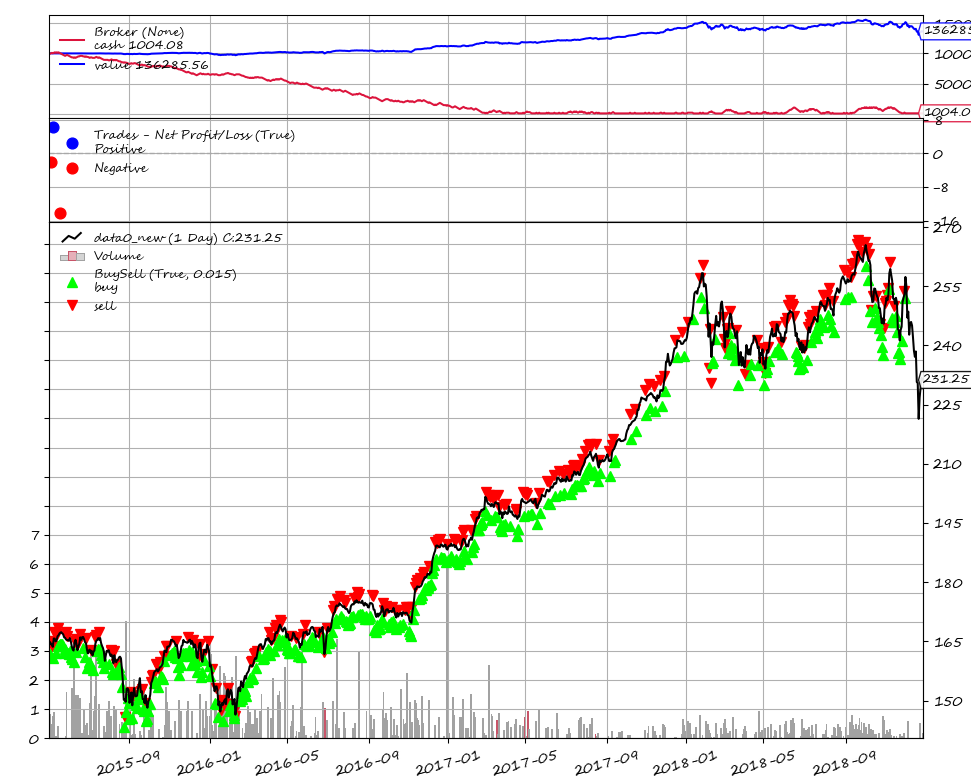

In [12]:
import pandas as pd
if __name__ == '__main__':
    #sentiment=pd.read_excel("/Users/tyllersun/Desktop/大一/data_science/bond.csv")
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(sentiment_strategy)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result

Starting Portfolio Value: 100000.00
Final Portfolio Value: 102119.15


<IPython.core.display.Javascript object>


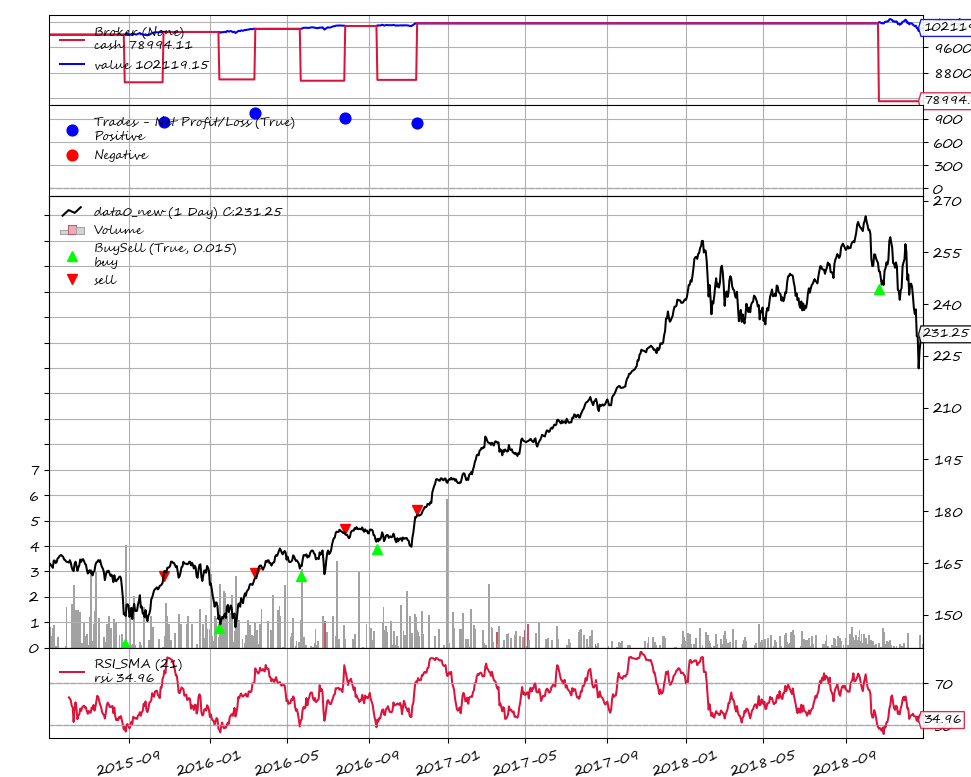

In [14]:
if __name__ == '__main__':
    #sentiment=pd.read_excel("/Users/tyllersun/Desktop/大一/data_science/bond.csv")
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(RSI_Strategy)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100041.34


<IPython.core.display.Javascript object>


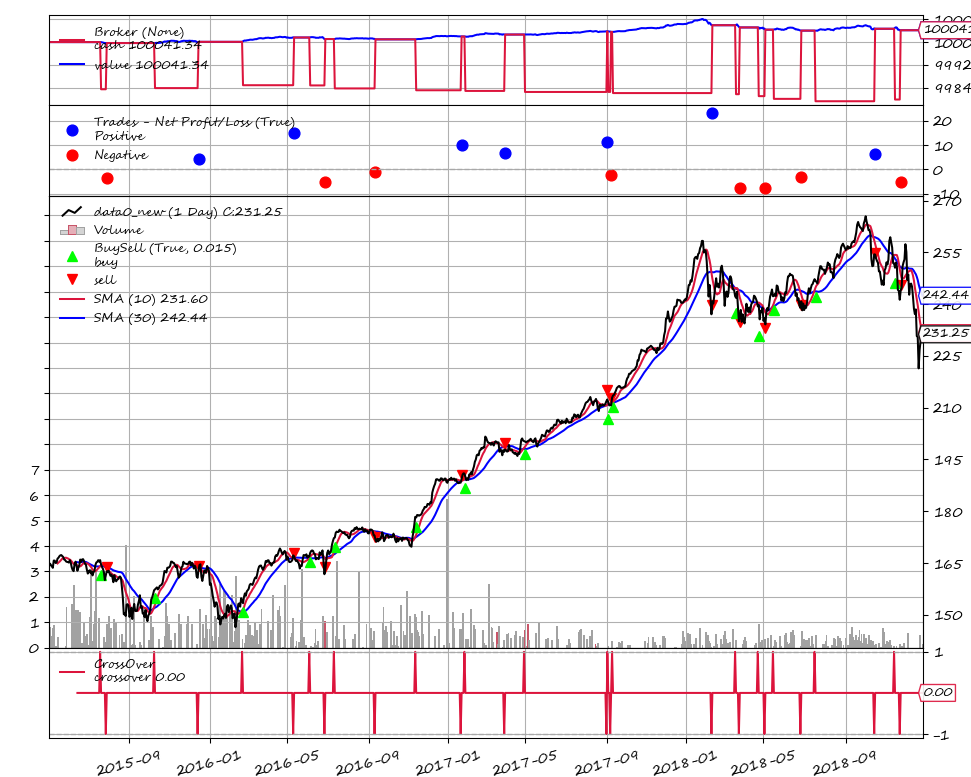

In [16]:
if __name__ == '__main__':
    #sentiment=pd.read_excel("/Users/tyllersun/Desktop/大一/data_science/bond.csv")
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(MA_CrossOver)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result
